**Geometry operations  on vector data**

This notebook is based on the material available [HERE](https://py.geocompx.org/04-geometry-operations#sec-subsetting-vs-clipping). 

# 1. Preparing the environment
## 1.1. Import libraries

In [39]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask

## 1.2.  Load datasets

In [8]:
m_root=r"C:/Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2024_2/2024_2_Programacion_SIG/Geocompy/"
seine = gpd.read_file(m_root+'data/seine.gpkg')
us_states = gpd.read_file(m_root+'data/us_states.gpkg')
nz = gpd.read_file(m_root+'data/nz.gpkg')
src = rasterio.open(m_root+'data/dem.tif')
src_elev = rasterio.open(m_root+'output/elev.tif')

# 2. Geometric operations on vector data

In [58]:
## 2.1. Polylines

<span style="color:red;"><strong>Question 2.1: check the type of geometry of the dataframe seine:</strong></span>

In [61]:
#Write your script here

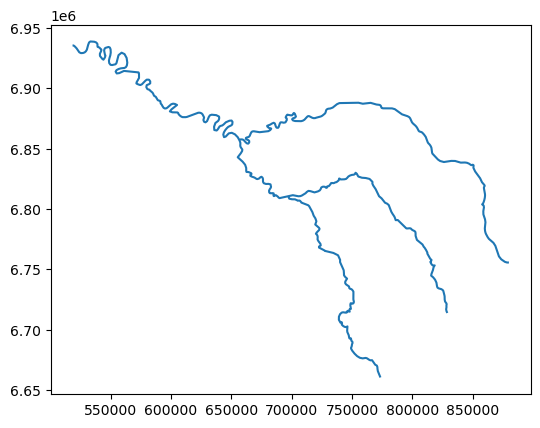

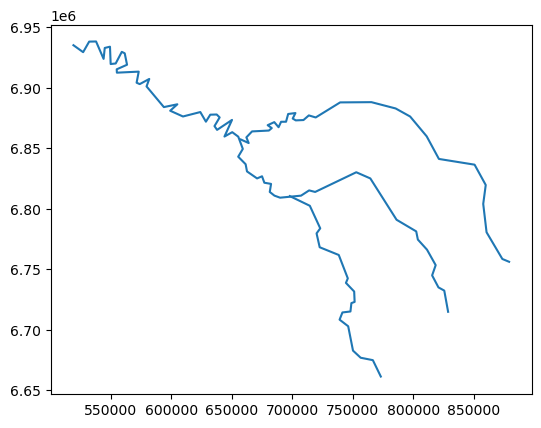

In [47]:
### Simplification
seine_simp = seine.simplify(2000)
seine.plot();
seine_simp.plot();
#seine.explore()

<span style="color:red;"><strong>🧠 Question 2.1.1.: What are the parameters of the simplify function? What do they represent?</strong></span>




 Show the size (bytes) that the objects seine y seine_simp ocuppy in the memory. 

In [31]:
print(f'Original: {sys.getsizeof(seine)} bytes')
print(f'Simplified: {sys.getsizeof(seine_simp)} bytes')

Original: 374 bytes
Simplified: 188 bytes


## 2.2. Simplify Polygons

In [63]:
us_states9311 = us_states.to_crs(9311)
us_states_simp1 = us_states9311.simplify(100000)

### Using topojson

In [93]:
topo = tp.Topology(us_states9311, prequantize=False)
#print(topo)
us_states_simp2 = topo.toposimplify(100000).to_gdf()

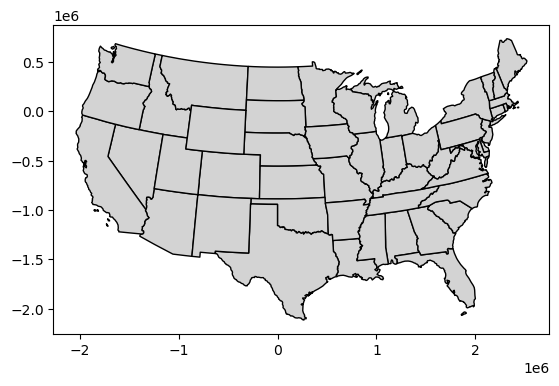

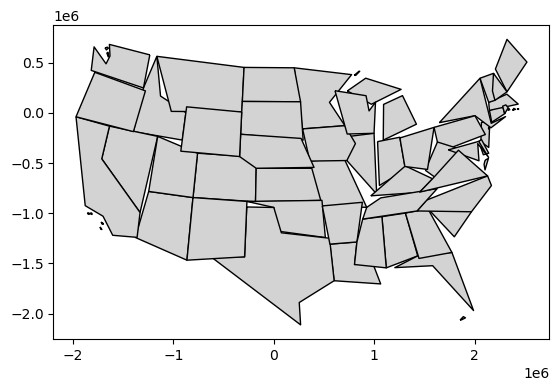

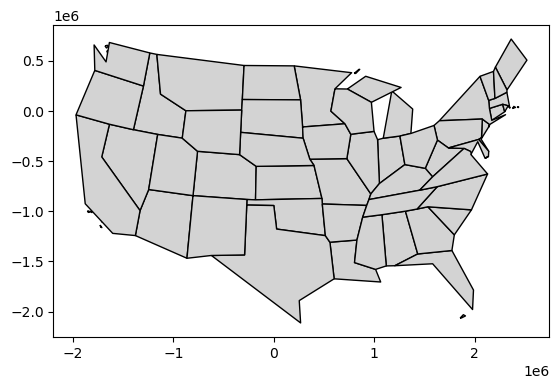

In [68]:
us_states9311.plot(color='lightgrey', edgecolor='black');
us_states_simp1.plot(color='lightgrey', edgecolor='black');
us_states_simp2.plot(color='lightgrey', edgecolor='black');

<span style="color:red;"><strong>🧠 Question 2.2.1. It seems it is a bit difficult to identify which map is each. Write a script to add titles to the maps</strong></span>


In [109]:
#Write your script here

##  2.4. Centroids

 Geographic centroid: represents the center of mass.

In [87]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

However, sometimes centroid falls outside boundaries of its parent objects. Then, we use the .representative_point method.

In [99]:
nz_pos = nz.representative_point()
seine_pos = seine.representative_point()

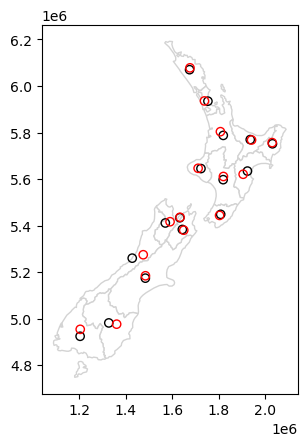

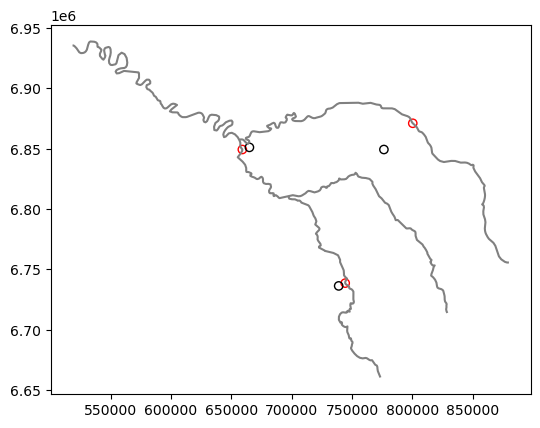

In [103]:
nz_pos = nz.representative_point()
seine_pos = seine.representative_point()
# New Zealand
base = nz.plot(color='white', edgecolor='lightgrey')
nz_centroid.plot(ax=base, color='None', edgecolor='black')
nz_pos.plot(ax=base, color='None', edgecolor='red');
# Seine
base = seine.plot(color='grey')
seine_pos.plot(ax=base, color='None', edgecolor='red')
seine_centroid.plot(ax=base, color='None', edgecolor='black');

<span style="color:red;"><strong>🧠 Question 2.4.1. It seems it is a bit difficult to identify which map is each. Write a script to add titles to the maps</strong></span>


In [113]:
# Write your script here

## 2.5. Buffers

In [127]:
seine_buff_5km = seine.buffer(5000)
seine_buff_50km = seine.buffer(50000)

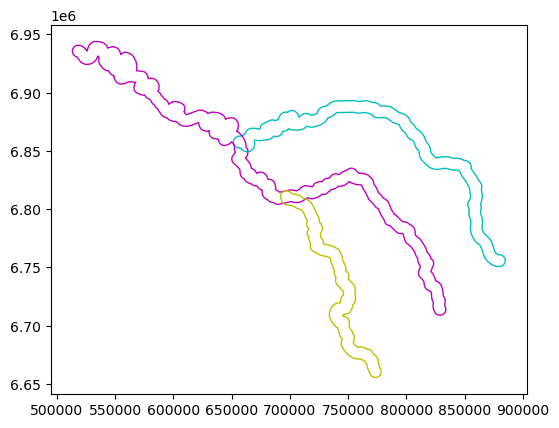

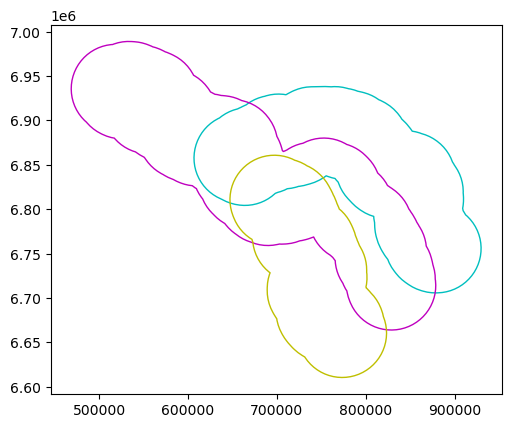

In [129]:
seine_buff_5km.plot(color='none', edgecolor=['c', 'm', 'y']);
seine_buff_50km.plot(color='none', edgecolor=['c', 'm', 'y']);

<span style="color:red;"><strong>🧠 Question 2.5.1. Check the data type of the output buffer</strong></span>


 Buut...what if we wnat to keep the attributes of the original dataset???

### 2.5.1. Replace the existing geometry with the new GeoSeries 

In [140]:
# Create a copy of the original GeoDataFrame
seine_buff_5km = seine.copy()

# Assigning the new buffer GeoSeries to the geometry column.
seine_buff_5km.geometry = seine.buffer(5000)
seine_buff_5km

,name,geometry
0,Marne,"POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,Seine,"POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,Yonne,"POLYGON ((701519.740 6813075.492, 702765.277 6..."


2.5.2. Or... add a secondary geometry column directly to the original GeoDataFrame.


In [152]:
seine['geometry_5km'] = seine.buffer(5000)
seine

,name,geometry,geometry_5km
0,Marne,"MULTILINESTRING ((879955.277 6755724.892, 8784...","POLYGON ((657550.332 6852587.977, 657528.383 6..."
1,Seine,"MULTILINESTRING ((828893.615 6713872.817, 8282...","POLYGON ((517151.801 6930724.103, 516742.424 6..."
2,Yonne,"MULTILINESTRING ((773482.137 6660431.284, 7713...","POLYGON ((701519.740 6813075.492, 702765.277 6..."


You can then switch to either geometry column using .set_geometry:

In [156]:
seine = seine.set_geometry('geometry_5km')


<span style="color:red;"><strong>🧠 Question 2.5.2. Rrevert to the original state of seine</strong></span>

In [159]:
# Write your script here

## 2.6. Affine transformations

Affine transformations are a type of geometric transformation that preserve:

* Rectilinearity (straight lines remain straight),
* Parallelism (parallel lines stay parallel),
* Proportionality of distances (distances along the same line change consistently).
  
They do not necessarily preserve:

* Exact lengths (they can scale or distort distances),
* Angles (rotations, tilts, etc. can alter the original angle).
* Hence, affine transformations include translations, rotations, scalings, shears, and even reflections. In algebraic terms, an affine transformation can be seen as a combination of a linear transformation (matrix) and a translation (vector), which is why it is referred to as “affine.”

For more details on affine transformations, check out the [LINK](https://pygis.io/docs/d_affine.html).

The method is always applied to the Geometry Geoseries. 


In [203]:
nz_shift = nz.translate(0, 100000)
print("nz_shift \n",nz_shift.head(2))
print("nz \n",nz.head(2))

#Scale
nz_scale = nz.scale(0.5, 0.5, origin='centroid')
print("nz_scale \n",nz_scale.head(2))

#Rotate
nz_rotate = nz.rotate(-30, origin='centroid')
print("nz_rotate \n",nz_rotate.head(2))

nz_shift 
 0    MULTIPOLYGON (((1745493.196 6101802.169, 17405...
1    MULTIPOLYGON (((1803822.103 6000006.143, 17914...
dtype: geometry
nz 
         Name Island     Land_area  Population  Median_income  Sex_ratio  \
0  Northland  North  12500.561149    175500.0          23400   0.942453   
1   Auckland  North   4941.572557   1657200.0          29600   0.944286   

                                            geometry  
0  MULTIPOLYGON (((1745493.196 6001802.169, 17405...  
1  MULTIPOLYGON (((1803822.103 5900006.143, 17914...  
nz_scale 
 0    MULTIPOLYGON (((1710099.077 6035906.652, 17076...
1    MULTIPOLYGON (((1778686.524 5917378.416, 17724...
dtype: geometry
nz_rotate 
 0    MULTIPOLYGON (((1701904.887 5975546.319, 16942...
1    MULTIPOLYGON (((1779714.772 5879525.450, 17692...
dtype: geometry


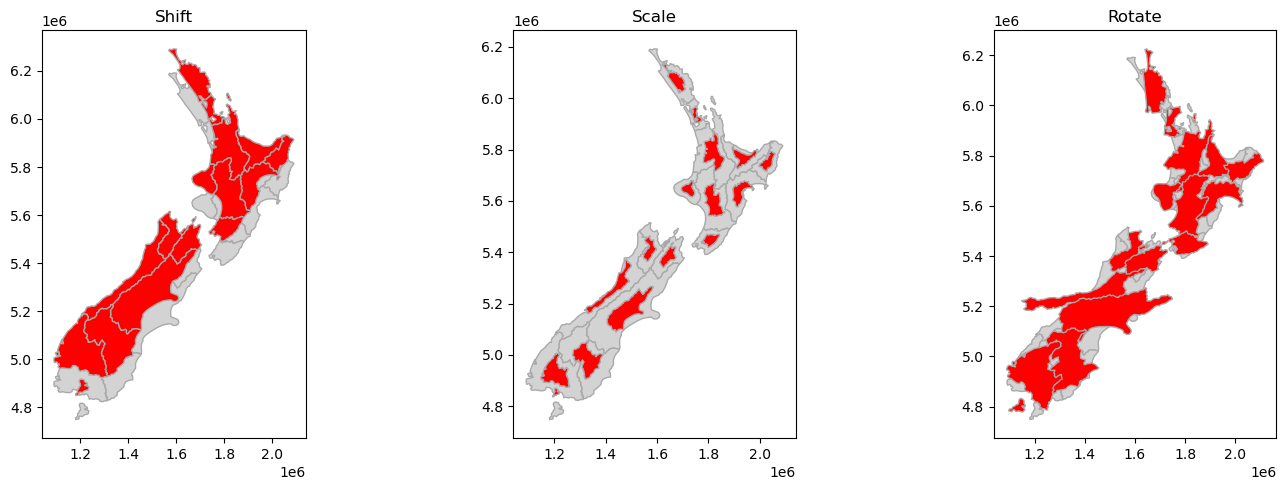

In [207]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# SHIFT
base_shift = nz.plot(ax=axes[0], color='lightgrey', edgecolor='darkgrey')
nz_shift.plot(ax=base_shift, color='red', edgecolor='darkgrey')
axes[0].set_title("Shift")

# SCALE
base_scale = nz.plot(ax=axes[1], color='lightgrey', edgecolor='darkgrey')
nz_scale.plot(ax=base_scale, color='red', edgecolor='darkgrey')
axes[1].set_title("Scale")

# ROTATE
base_rotate = nz.plot(ax=axes[2], color='lightgrey', edgecolor='darkgrey')
nz_rotate.plot(ax=base_rotate, color='red', edgecolor='darkgrey')
axes[2].set_title("Rotate")

plt.tight_layout()
plt.show()


## 2.7.Pairwise geometry-generating operations

New geometries are generated from two inputs.
For ecample, spatial clipping is a form of spatial subsetting. Itchanges to the geometry columns of at least some of the affected features

### Pairwise operations between individual shapely geometries

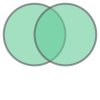

In [211]:
x = shapely.Point((0, 0)).buffer(1)
y = shapely.Point((1, 0)).buffer(1)
shapely.GeometryCollection([x, y])

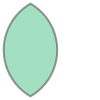

In [220]:
# Intersection
x.intersection(y)

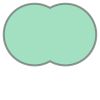

In [218]:
x.union(y)

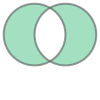

In [222]:
x.symmetric_difference(y)

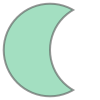

In [224]:
x.difference(y)

###  Pairwise methods on a GeoSeries or GeoDataFrame

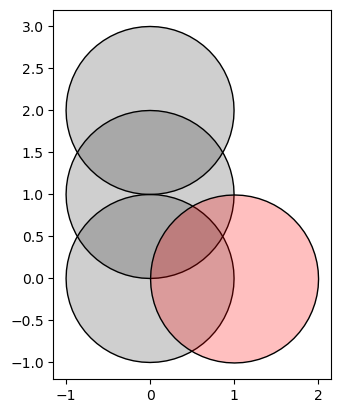

In [251]:
# geom1: create a GeoSeries based on 'x'
geom1 = gpd.GeoSeries(x)

# geom2: translate the original geometry 0 units in X and 1 unit in Y
geom2 = geom1.translate(0, 1)

# geom3: translate the original geometry 0 units in X and 2 units in Y
geom3 = geom1.translate(0, 2)

# geom: combine (concatenate) the original geometry and its two translated versions
geom = pd.concat([geom1, geom2, geom3])

# Display the resulting combined GeoSeries
geom


fig, ax = plt.subplots()
geom.plot(color='#00000030', edgecolor='black', ax=ax)
gpd.GeoSeries(y).plot(color='#FF000040', edgecolor='black', ax=ax);

<span style="color:red;"><strong>🧠 Question 2.7.2. Could you explain line by line what the last script did? Which cicrle(s) are/is shapefile object and which a Geoseries? </strong></span>

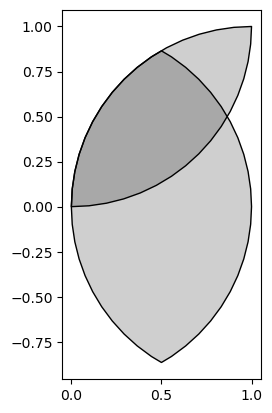

In [259]:
geom_inter_y = geom.intersection(y)
geom_inter_y
geom_inter_y.plot(color='#00000030', edgecolor='black');

<span style="color:red;"><strong>🧠 Question 2.7.3. What is the difference of using intersection vs using overlay? </strong></span>

## 2.8. Clipping and subsetting

<span style="color:red;"><strong>🧠 Question 2.7.3. What is the difference between clipping and subsetting? </strong></span>

## 2.9. Geometry unions

Please explain what does the following script do:

In [269]:
regions = us_states[['REGION', 'geometry', 'total_pop_15']] \
    .dissolve(by='REGION', aggfunc='sum').reset_index()
regions

,REGION,geometry,total_pop_15
0,Midwest,"MULTIPOLYGON (((-89.10077 36.94397, -89.19948 ...",67546398.0
1,Norteast,"MULTIPOLYGON (((-75.61724 39.83423, -75.78860 ...",55989520.0
2,South,"MULTIPOLYGON (((-81.38550 30.27384, -81.25671 ...",118575377.0
3,West,"MULTIPOLYGON (((-118.36998 32.83927, -118.4963...",72264052.0


Compare the original us_states layer with the aggregated regions layer.

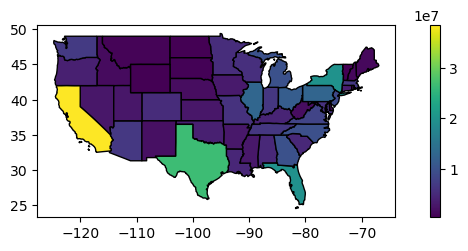

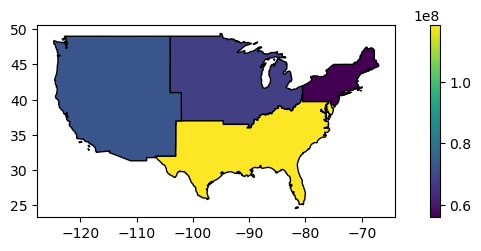

In [271]:
# States
fig, ax = plt.subplots(figsize=(9, 2.5))
us_states.plot(ax=ax, edgecolor='black', column='total_pop_15', legend=True);
# Regions
fig, ax = plt.subplots(figsize=(9, 2.5))
regions.plot(ax=ax, edgecolor='black', column='total_pop_15', legend=True);

<span style="color:red;"><strong>🧠 Question 2.8.1. Add a title to each image </strong></span>